# Make Gradient Plots

This is another visual of the chromosome event. This displays the events through gradients.

## Setup

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cptac
import numpy as np
import cnvutils
import matplotlib as mpl

cptac warning: Your version of cptac (0.8.5) is out-of-date. Latest is 0.8.6. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-11ef73797931>, line 4)


In [2]:
# Indicate the chromosome you would like to look at.
CHROMOSOME = '8'
# Indicate whether you want to look at gain, loss or both
GAIN_OR_LOSS = 'both'
# Indicate the cancer types you want plotted
CANCER_TYPES = ['BRCA', 'CCRCC', 'COLON', 'ENDO', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OVARIAN']

In [3]:
counts = pd.read_csv("cnv_counts.tsv", sep='\t', usecols=['Name', 'Database_ID', 'start_bp', 'end_bp', 'variable', 'value','chromosome', 'cancer'])

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
reds = ['#FFFFFF', '#FDF0F0', '#FCE2E2', '#FAD3D3', '#F8C5C5', '#F6B6B6', '#F5A7A7', '#F39999', '#F18A8A', '#EF7B7B', '#EE6D6D', '#EC5E5E', '#EA5050', '#E84141', '#E73232', '#E52424', '#E31515']
blues = ['#FFFFFF', '#F2F0FD', '#E5E0FA', '#D7D1F8', '#CAC2F5', '#BDB2F3', '#B0A3F0', '#A393EE', '#9684EB', '#8875E9', '#7B65E6', '#6E56E4', '#6147E1', '#5437DF', '#4628DC', '#3918DA', '#2C09D7']
gradient = blues[::-1] + reds

## Prepare Tables

In [5]:
chromosome_counts = counts[counts.chromosome == CHROMOSOME]

In [6]:
gain_loss_counts = chromosome_counts.pivot_table(index=['Name', 'cancer'], columns='variable')
gain_loss_counts.columns = gain_loss_counts.columns.to_flat_index()
gain_loss_counts = gain_loss_counts.drop(columns=('start_bp', 'gain'))
gain_loss_counts = gain_loss_counts.drop(columns=('end_bp', 'gain'))
gain_loss_counts = gain_loss_counts.rename(columns = {gain_loss_counts.columns[0]: 'end_bp', gain_loss_counts.columns[1]: 'start_bp', gain_loss_counts.columns[2]: 'gain', gain_loss_counts.columns[3]: 'loss'}, )

In [7]:
gain_loss_counts['length'] = gain_loss_counts.end_bp - gain_loss_counts.start_bp
gain_loss_counts['value'] = gain_loss_counts.gain - gain_loss_counts.loss
gain_loss_counts['bars'] = list(zip(gain_loss_counts.start_bp, gain_loss_counts.length))

## Map Colors

In [8]:
def map_color(val):
    i = (val + 85) // 5
    if i < 0:
        i = 0
    if i > 33:
        i=33
    return gradient[int(i)]

In [9]:
def map_reds(val):
    i = val // 5
    if i > 16:
        i = 16
    return reds[int(i)]

In [10]:
def map_blues(val):
    i = val // 5
    if i > 16:
        i = 16
    return blues[int(i)]

In [11]:
if GAIN_OR_LOSS == 'both':
    gain_loss_counts['color'] = gain_loss_counts.value.apply(map_color)
elif GAIN_OR_LOSS == 'gain':
    gain_loss_counts['color'] = gain_loss_counts.gain.apply(map_reds)
elif GAIN_OR_LOSS == 'loss':
    gain_loss_counts['color'] = gain_loss_counts.loss.apply(map_blues)
else:
    print("Error! GAIN_OR_LOSS has the following options: 'gain', 'loss', 'both'")

In [12]:
gain_loss_counts.reset_index(inplace=True)

## Load in cancer driver genes
This data comes from the article "Comprehensive Characterization of Cancer Driver Genes and Mutations" ([29625053](https://pubmed.ncbi.nlm.nih.gov/29625053/))


In [13]:
# You may need to change the path to this file
driver_genes = pd.read_csv('../chromosome_8/bailey_driver_genes.csv', skiprows=3)

In [14]:
driver_genes = driver_genes.dropna(how="all")
driver_genes = driver_genes.dropna(how='all', axis=1)

## Create the plot

Text(0.12, -0.22, '$\\bf{Distribution\\ of\\ gain\\ and\\ loss\\ events\\ on\\ Chromosome\\ 8.}$Color was \n determined by taking the count of patients with gain minus the \n number of patients with a loss event, for each gene. E.g., a gene \n where 20 patients had a gain and 80 had a loss would be displayed \n at -60.')

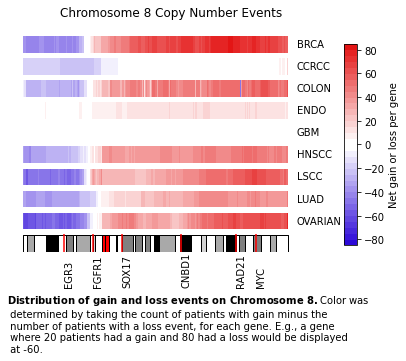

In [26]:
fig, ax = plt.subplots(nrows=len(CANCER_TYPES) + 1, sharex=True, sharey=False)

#If you would like to add a caption to your figure, you can add it here
txt = r"$\bf{Distribution\ of\ gain\ and\ loss\ events\ on\ Chromosome\ 8.}$" + "Color was \n determined by taking the count of patients with gain \
minus the \n number of patients with a loss event, for each gene. E.g., a gene \n where 20 patients had a gain and 80 had a \
loss would be displayed \n at -60."
count = 0
for cancer in CANCER_TYPES:
    df = gain_loss_counts[gain_loss_counts.cancer == cancer]
    df = df.sort_values('start_bp')
    start_values = df.start_bp
    continuous_values = list()
    prev = 0
    for val in start_values:
        continuous_values.append((prev, val-prev))
        prev = val
    ax[count].broken_barh(continuous_values, (0,1), facecolors=df.color)
    ax[count].text(np.max(start_values)+5000000, 0.35, cancer)
    ax[count].set_frame_on(False)
    ax[count].get_xaxis().set_visible(False)
    ax[count].get_yaxis().set_visible(False)
    count += 1
cnvutils.make_chromosome_plot(CHROMOSOME, ax=ax[count], genes=list(driver_genes.Gene.unique()), above=False)
# cnvutils.make_chromosome_plot(CHROMOSOME, ax=ax[count])

fig.subplots_adjust(right=0.8)
fig.suptitle(f"Chromosome {CHROMOSOME} Copy Number Events")
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
colors = mpl.colors.ListedColormap(gradient)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-85, vmax=85), cmap=colors), cax=cbar_ax)
cbar.ax.set_ylabel('Net gain or loss per gene')
fig.text(0.12, -.22, txt, ha='left')
# cbar.yaxis.set_

<module 'matplotlib.pyplot' from 'C:\\Users\\chels\\anaconda3\\envs\\notebooks\\lib\\site-packages\\matplotlib\\pyplot.py'>

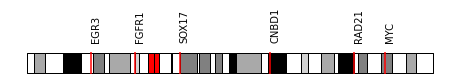

In [16]:
fig, ax = plt.subplots(figsize=(8,.4))
cnvutils.make_chromosome_plot(CHROMOSOME, ax=ax, genes=list(driver_genes.Gene.unique()), above=True)
